<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [30]:
# Подключим все необходимые библиотеки:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Изучим общую информацию о генеральной выборке и определим необходимость предобработки:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Данные выстроены в хронологическом порядке с временным интервалом в 10 минут. Такая точность излишня, поэтому проведём ресемплирование с суммированием данных:

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Предобработка закончена, можно переходить к анализу.
## Анализ
1. Рассмотрим численные показатели выборки методом `describe`;
1. Изучим суточный, недельный и месячный срезы;
1. Выведем тренды, сезонность и скользящие средние;
1. Определим является ли ряд стационарным.

In [6]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


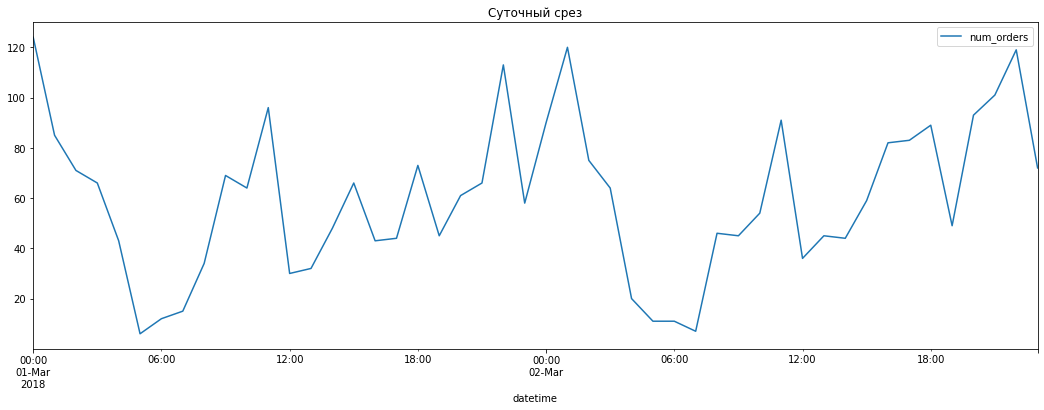

In [7]:
day_data = data['2018-03-01':'2018-03-02']
day_data.plot(figsize=[18,6], title = 'Суточный срез');

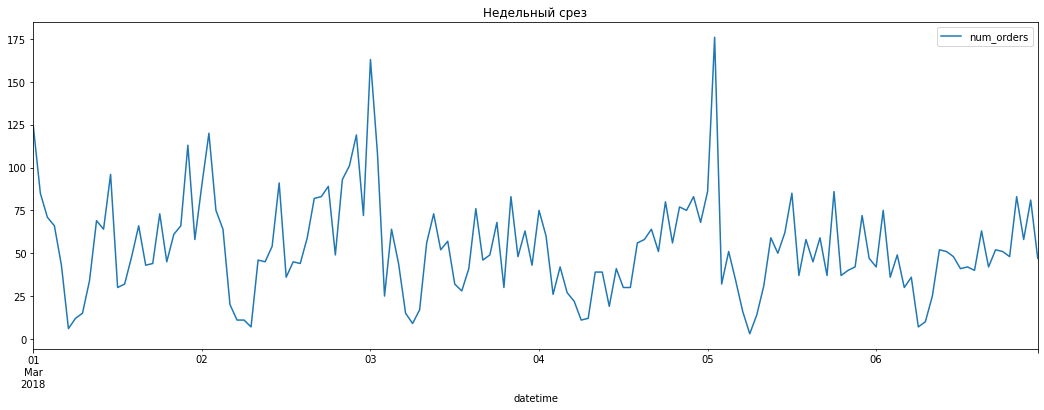

In [8]:
day_data = data['2018-03-01':'2018-03-06']
day_data.plot(figsize=[18,6], title = 'Недельный срез');

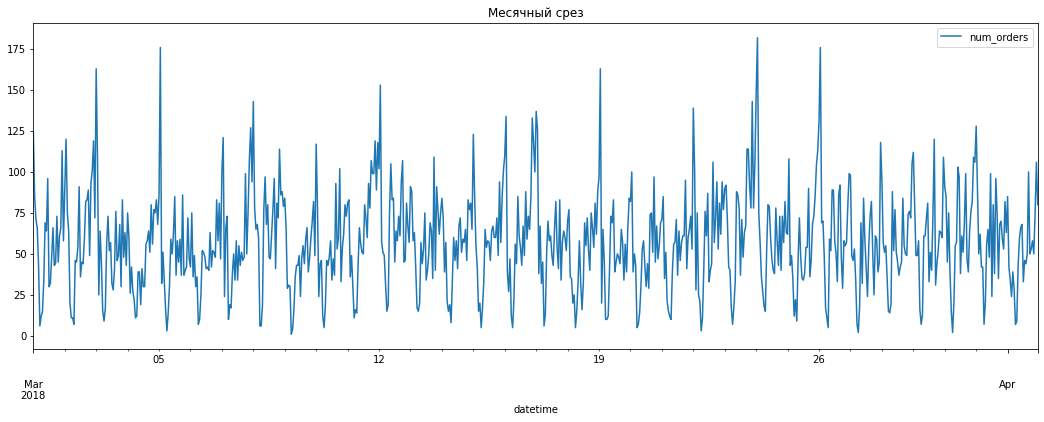

In [9]:
day_data = data['2018-03-01':'2018-04-01']
day_data.plot(figsize=[18,6], title = 'Месячный срез');

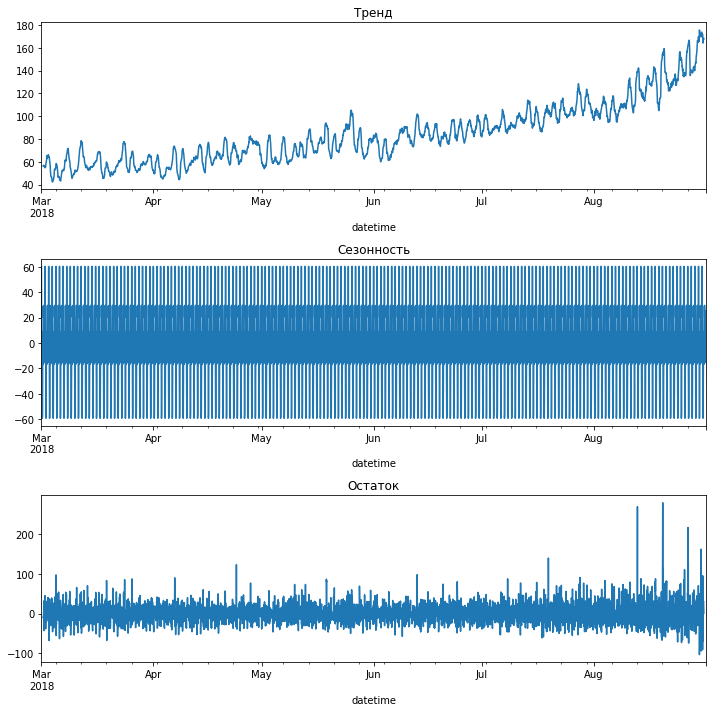

In [10]:
decomposed = seasonal_decompose(data['num_orders']) 

plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остаток')
plt.tight_layout()

График Сезонности для часовых временных промежутков нечитабелен. Выведем график сезонности на более коротком срезе - за первую неделю:

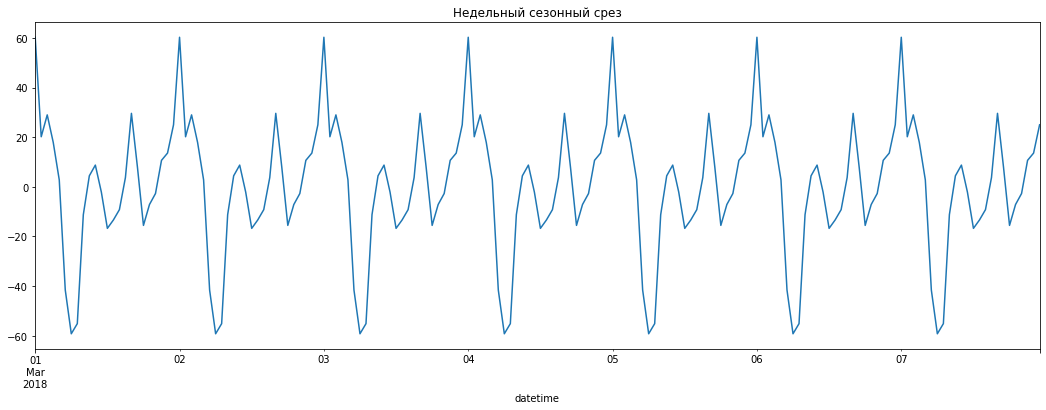

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(), figsize=[18,6], title = 'Недельный сезонный срез');

Замечена ежедневная сезонность. Так же, судя по графику тренда, временной ряд генеральной выборки нестационарный. Для дополнительно проверки рассмотрим скользящие средние:

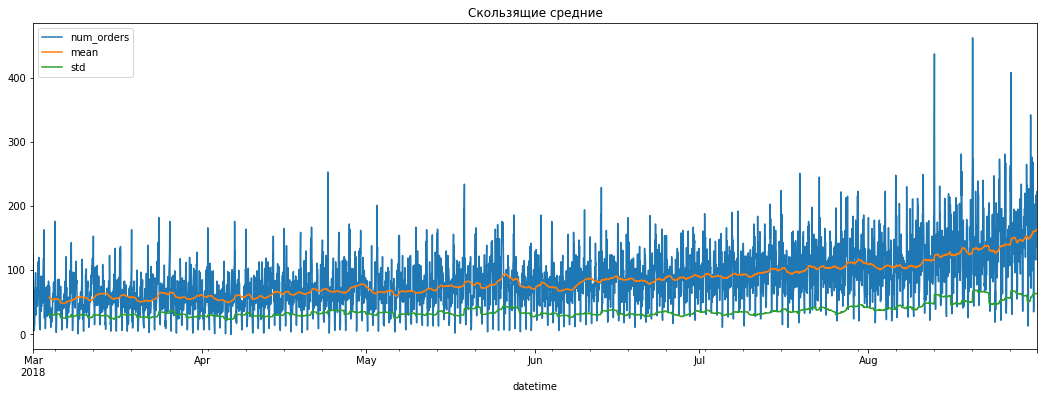

In [12]:
data['mean'] = data['num_orders'].rolling(72).mean()
data['std'] = data['num_orders'].rolling(72).std()
data.plot(figsize=[18,6], title = 'Скользящие средние');

В ходе анализа данных выявлено:
- Ежедневные колебания имеют сезонный характер;
- Количество заказов на такси растёт ближе к сентябрю, что объясняется повышенным спросом на услуги авиаперевозок в туристические сезоны;
- Временной ряд выборки имеет нестационарный характер.



In [13]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный



## Обучение
### Подготовка данных
Для корректного обучения модели временной ряд необходимо убедиться, что данные возможно привести к стационарному виду путём вычитания из ислледуемого временного ряда ряда, созданного с помощью метода `shift`:

<AxesSubplot:xlabel='datetime'>

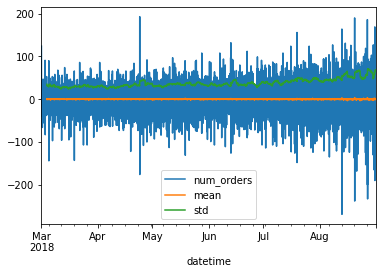

In [14]:
data_shifted = data - data.shift(fill_value=0)
data_shifted['mean'] = data_shifted['num_orders'].rolling(72).mean()
data_shifted['std'] = data_shifted['num_orders'].rolling(72).std()
data_shifted.plot()

Временной ряд стал стационарным. Следующим шагом станет добавление в выборку отдельными столбцами признаки (месяц, день, день недели, час), отстающие значения и скользящие средние. Выполним указанные задачи с помощью функции:

In [15]:
data = data.drop(['mean', 'std'], axis=1)
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(data, 168, 5)
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
make_features(data, 178, 12)

Признаки созданы. Разделим генеральную выборку на обучающую, валидационную и тестовую:

In [18]:
state = 0

train, test = train_test_split(data, test_size=0.1, shuffle=False)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print('Размер обучающей выборки составил', round(features_train.shape[0]/data.shape[0]*100, 2), '% от генеральной')
print('Размер тестовой выборки составил', round(features_test.shape[0]/data.shape[0]*100, 2), '% от генеральной')

Размер обучающей выборки составил 85.96 % от генеральной
Размер тестовой выборки составил 10.01 % от генеральной


In [19]:
data

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0,170.0
2018-08-31 20:00:00,154,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0,205.0
2018-08-31 21:00:00,159,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,179.0,113.0,137.0,170.0,188.0,117.0,88.0,144.0,118.0,151.0


### Линейная регрессия

Обучим модель Линейная регрессия и оценим качество её предсказаний с помощью метрики RMSE. Так же используем `TimeSplitter` в качестве аргумента параметра cv для адекватной работы кросс валидации временных рядов.

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

In [32]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=tscv)
rmse_lr = round(np.mean(-score_lr)**0.5, 2)
print('RMSE модели LR на обучающей выборке: {:.2f}'.format(rmse_lr))

RMSE модели CBR на обучающей выборке: 22.83


### CatBoostRegressor
Прежде чем обучать эту модель, подберём для неё наилучшие гиперпараметры с поомщью `grid search`. 

In [23]:
model_cbr = CatBoostRegressor()
params = {
    'verbose'     : [False],
    'random_state': [state],
    'depth'       : [4, 6, 8],
    'iterations'  : [10, 30, 50, 70]
    }

grid_cv = GridSearchCV(estimator=model_cbr, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
rmse_cbr = (-grid_cv.best_score_) ** 0.5 
cbr_params = grid_cv.best_params_

print('Лучшие гиперпараметры: ', grid_cv.best_params_)
print('RMSE модели CBR на обучающей выборке: {:.2f}'.format(rmse_cbr))

Лучшие гиперпараметры:  {'depth': 4, 'iterations': 70, 'random_state': 0, 'verbose': False}
RMSE модели CBR на обучающей выборке: 23.96


### RandomForestRegressor

In [34]:
model_rfr = RandomForestRegressor()
params = {
    'random_state': [state],
    'n_estimators': range(50, 101, 10),
    'max_depth'   : range(1, 11, 3),
    }

grid_cv = GridSearchCV(estimator=model_rfr, param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
rmse_rfr = (-grid_cv.best_score_) ** 0.5
rfr_params = grid_cv.best_params_

print('Лучшие гиперпараметры: ', grid_cv.best_params_)
print('RMSE модели CBR на обучающей выборке: {:.2f}'.format(rmse_rfr))

Лучшие гиперпараметры:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 0}
RMSE модели CBR на обучающей выборке: 23.11


Сведём результаты обучения в одну таблицу для наглядности:

In [35]:
models = [['LR', rmse_lr], ['CBR', rmse_cbr], ['RFR', rmse_rfr]] 
    
results = pd.DataFrame(models, columns = ['Модель', 'RMSE']) 
results.set_index('Модель')
results

,Модель,RMSE
0,LR,22.83000
1,CBR,23.95966
2,RFR,23.11043


Лучший результат показала модель Линейная Регрессия. Переходим к этапу тестирования.

## Тестирование

In [40]:
model_test = LinearRegression()
model_test.fit(features_train, target_train)

predict_test = model_test.predict(features_test)
rmse_test = rmse(target_test, predict_test)
print('RMSE модели LR на тестовой выборке: {:.2f}'.format(rmse_test))

RMSE модели LR на тестовой выборке: 38.82


Проверим на дамми модели:

In [39]:
dummy = DummyRegressor()
dummy.fit(features_train, target_train)

dummy_test = dummy.predict(features_test)
rmse_test = rmse(target_test, dummy_test)
print('RMSE модели RFR на тестовой выборке: {:.2f}'.format(rmse_test))

RMSE модели RFR на тестовой выборке: 83.95


Выбранная модель показала значительно меньшую среднеквадратичную ошибку, чем дамми модель. Модель адекватна.

## Выводы

1. Генеральная выборка представляет собой хронологически упорядоченные данные о вызове такси с интервалом в 10 минут;
1. Данные были ресемплированы до 1 часа и изучены:
    - Ежедневные колебания имеют сезонный характер;
    - Количество заказов на такси растёт ближе к сентябрю, что объясняется повышенным спросом на услуги авиаперевозок в туристические сезоны;
    - Временной ряд выборки имеет нестационарный характер, однако может быть приведён к стационарному, следовательно, быть предметом обучения модели.
1. Обученные модели показали следующие метрики RMSE:
    - LinearRegression : 22.83
    - CatBoostRegressor : 23.96
    - RandomForestRegressor : 23.11
1. Предсказания модели Линейная Регрессия на тестовой выборке имеет среднеквадратичное отколнение эквивалентное 38.92 и пригодна для дальнейших предсказаний и работы.